# data_selection_and_cleaning

This notebook deals with selecting features to use for estimating the NOx emissions, and visualising them / cleaning them if necessary.

It also deals with finding reasonable scalers / transformers to use.

In [20]:
### set path to include custom functions
import sys
sys.path.insert(0, '../PythonScripts/')

### libraries

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# data manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, PowerTransformer



# stats
from scipy.stats import kurtosis, skew


In [67]:
def plotting(x, activation = None, normalization = None, plot = True, **kwargs):
    x_cols = x.columns
    x = x.copy()
    x = np.asarray(x)

    if activation:
        x = activation(x, **kwargs)
        activation = activation.__name__.upper()
    else:
        activation = 'NONE'
        
        
    if normalization:
        x = normalization().fit_transform(x)
        normalization = normalization.__name__.upper()
    else:
        normalization = 'NONE'
        
    if plot: 
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,8))
        fig.suptitle(('The distribution of the data with {} normalization for an activation'
                      ' function of {}'.format(normalization ,activation)), fontsize=16)

        for i in range(x.shape[1]):
            ax[0].hist(x[:,i], alpha = 0.2)
        ax[0].legend(x_cols)   
        ax[1] = sns.boxplot(data = x)
        plt.xticks(rotation=15)
        plt.show()

    return pd.DataFrame(data = x, columns = x_cols), kurtosis(x), skew(x)


def root(x, power = 1/2, inverse = False):
    return x ** power if not inverse else x ** 1/power


def log(x, inverse = False):
    return np.log(x) if not inverse else np.exp(x)



def tanh(x):
    return np.tanh(x)


activations = [log, root, tanh]

transformers = [RobustScaler, MinMaxScaler, StandardScaler, PowerTransformer]

In [15]:
path = '../data/Boston_Housing_Market_Challenge/boston_corrected.csv'

df = pd.read_csv(path)

df.head()

,TOWN,TOWNNO,TRACT,LON,LAT,MEDV,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,Nahant,0,2011,-70.955,42.2550,24.0,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,Swampscott,1,2021,-70.950,42.2875,21.6,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,Swampscott,1,2022,-70.936,42.2830,34.7,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,Marblehead,2,2031,-70.928,42.2930,33.4,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,Marblehead,2,2032,-70.922,42.2980,36.2,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


In [32]:
columns_of_interest = [
    'CMEDV', 'CRIM', 'INDUS', 'NOX', 'AGE', 'DIS', 'RAD', 'LSTAT'
]

In [38]:
# make a copy

df_main = df.copy()[columns_of_interest]

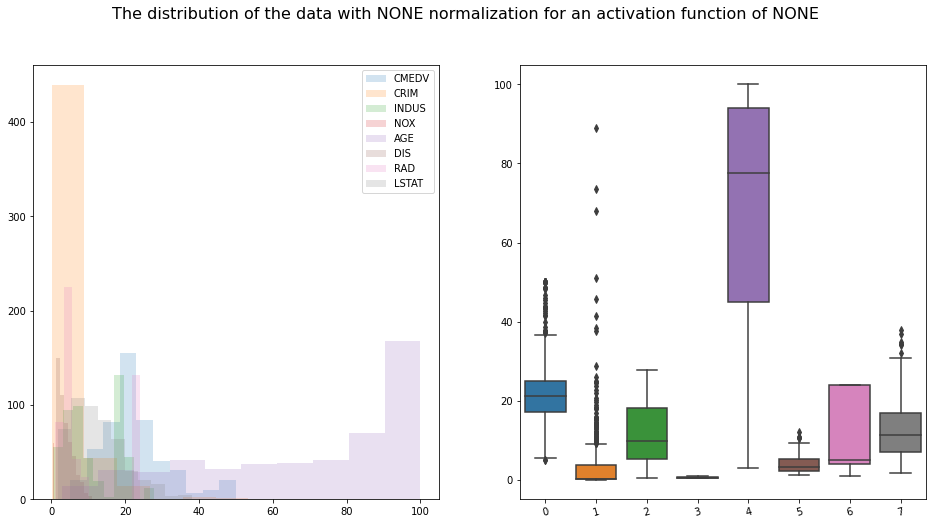

In [39]:
df_analysis, kurts, skews = plotting(df_main)



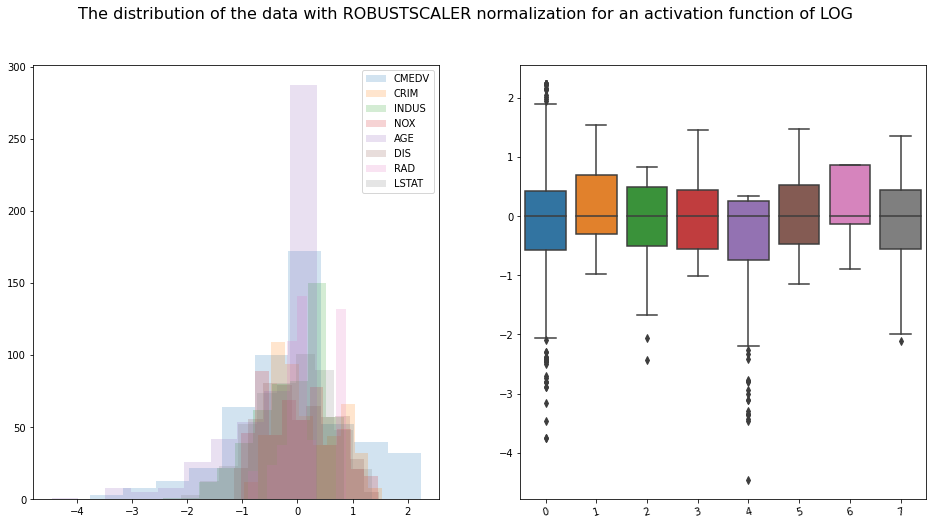

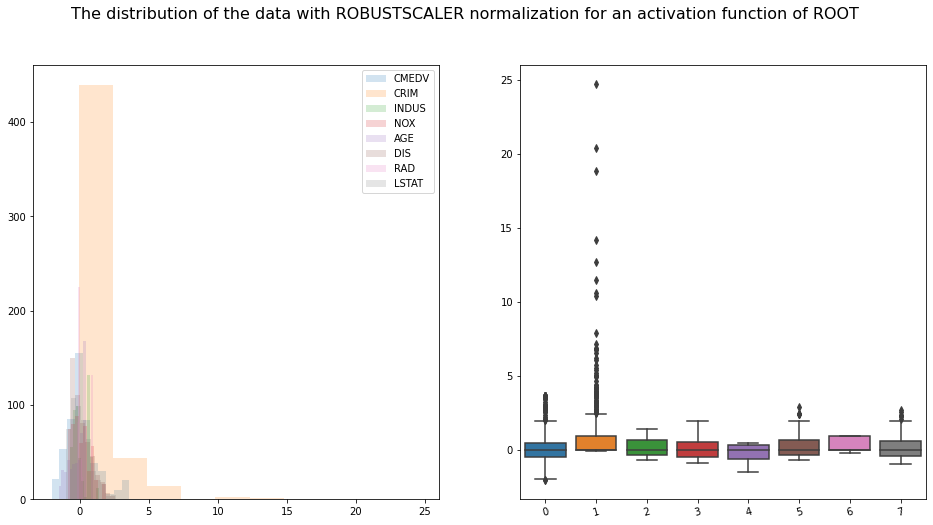

In [43]:
# analyse with different combinations

# to reduce positive skew
df_analysis, kurts, skews = plotting(df_main, activation = log, normalization = RobustScaler)
# looks better? Can you try others?


df_analysis, kurts, skews = plotting(df_main, activation = root, normalization = RobustScaler,
                                  power = 3,
                                  inverse = True)


# optimisation to select the best combination for each one

In [96]:

skewness_init = 1
kurtosis_init = 3


min_kurt = np.asarray([kurtosis_init for item in columns_of_interest])
min_skew = np.asarray([skewness_init for item in columns_of_interest])

ideal_transformers = np.asarray(['BLANK' for item in columns_of_interest])
ideal_activations = np.asarray(['BLANK' for item in columns_of_interest])

for activation in activations:
    for transformer in transformers:
        x, kurts, skews = plotting(df_main, activation, transformer, plot = False)
        # only chooses activation and transformer as optimal when BOTH
        # kurtosis and skew are below the min values

        boolean_cond = np.logical_and(
            np.abs(kurts) < min_kurt, np.abs(skews) < min_skew
        )


        min_kurt = np.asarray([
            val if condition else curr_kurt for curr_kurt, val, condition in zip(min_kurt,kurts, boolean_cond)
        ])
        
        min_skew = np.asarray([
            val if condition else curr_skew for curr_skew, val, condition in zip(min_skew,skews, boolean_cond)
        ])
        
        ideal_transformers[boolean_cond] = transformer.__name__
        ideal_activations[boolean_cond] = activation.__name__

/Users/yousefnami/opt/anaconda3/envs/ai_hack_2021/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/yousefnami/opt/anaconda3/envs/ai_hack_2021/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


In [97]:
ideal_activations

array(['log', 'log', 'log', 'log', 'log', 'log', 'log', 'log'],
      dtype='<U5')

In [98]:
ideal_transformers

array(['Robus', 'Robus', 'Robus', 'Robus', 'Power', 'Robus', 'Robus',
       'Robus'], dtype='<U5')

# Conclusions and Thoughts

Age: seems to be a value that we'd be interested in? Older houses may have wood fired chimneys --> more NOx

LON/LAT or TOWN: this gives information about how close parameters are. They might also provide noise to the dataset though. Leaning towards LON/LAT since they are already continuous!

CMEDV: house price naturally

DIS: distance from employment centres

Refer to the HTML reports for more insight.